<a href="https://colab.research.google.com/github/JulienGremillot/OpenClassrooms_Ingenieur_Machine_Learning/blob/main/P7%20-%20D%C3%A9veloppez%20une%20preuve%20de%20concept/D%C3%A9veloppez_une_preuve_de_concept_1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten,\
    Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation,\
    RandomContrast, Dropout, BatchNormalization, GlobalAveragePooling1D,\
    GlobalAveragePooling2D, Dense, Embedding, Add,\
    Normalization, Resizing, Layer, LayerNormalization, MultiHeadAttention
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy,\
    SparseTopKCategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import loadmat
from PIL import Image
from numpy import asarray
import numpy as np
import pandas as pd
!pip install tensorflow-addons
import tensorflow_addons as tfa

In [2]:
drive._mount('/content/drive', force_remount=False)
os.chdir("/content/drive/MyDrive/Colab Notebooks")
print("Répertoire de travail courant : %s" % os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Répertoire de travail courant : /content/drive/MyDrive/Colab Notebooks



```
----------------------------------------
Metadata/Annotations
----------------------------------------
Descriptions of the files are as follows:

-cars_meta.mat:
  Contains a cell array of class names, one for each class.

-cars_train_annos.mat:
  Contains the variable 'annotations', which is a struct array of length
  num_images and where each element has the fields:
    bbox_x1: Min x-value of the bounding box, in pixels
    bbox_x2: Max x-value of the bounding box, in pixels
    bbox_y1: Min y-value of the bounding box, in pixels
    bbox_y2: Max y-value of the bounding box, in pixels
    class: Integral id of the class the image belongs to.
    fname: Filename of the image within the folder of images.
```




Je charge les fichiers de données et les constantes utiles

In [3]:
IDX_CLASS_ID = 5  # index de l'id de classe dans le .mat
IDX_FILENAME = 0  # index du nom de fichier dans le .mat
IMAGES_DIR_10 = "cars_ims_10"
cars_meta = loadmat('cars_meta.mat')['class_names'][0]
cars_annos = loadmat('cars_annos.mat')['annotations'][0]

J'examine les premières entrées du jeu de données

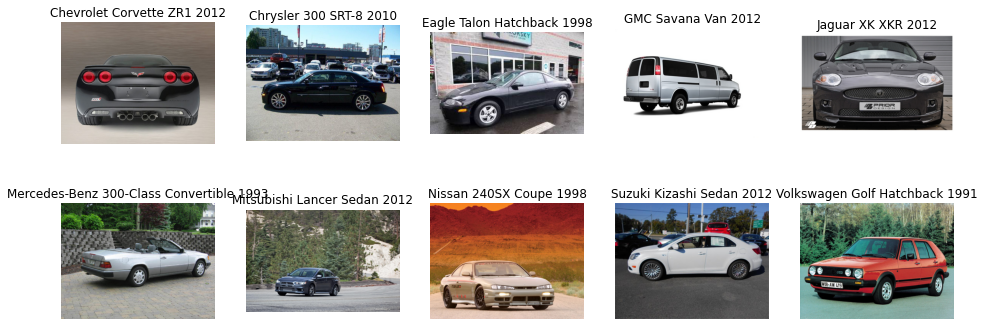

In [4]:
i = 1
top_classes_ids = []
plt.figure(figsize=(16, 6))
for car in cars_annos:
    class_id = int(car[IDX_CLASS_ID][0][0])
    class_name = cars_meta[class_id - 1][0].replace('/', '')
    if os.path.exists(os.path.join(IMAGES_DIR_10, class_name))\
      and class_id not in top_classes_ids:
        top_classes_ids.append(class_id)
        fname = car[IDX_FILENAME][0].split('/')[1]
        img = Image.open(os.path.join(IMAGES_DIR_10, class_name, fname))
        plt.subplot(2, 5, i)
        plt.title(class_name)
        plt.imshow(img)
        plt.axis("off")
        i += 1
        if i > 10:
            break
        

Je charge le jeu de données dans un DataFrame

In [5]:
top_classes_ids

[56, 79, 98, 119, 144, 161, 167, 171, 182, 191]

In [6]:
filenames = []
class_ids = []  # index dans la liste top_classes_ids
for car in cars_annos:
    class_id = int(car[IDX_CLASS_ID][0][0])
    if class_id in top_classes_ids:
        class_name = cars_meta[class_id - 1][0].replace('/', '')
        fname = car[IDX_FILENAME][0].split('/')[1]
        fname = os.path.join(IMAGES_DIR_10, class_name, fname)
        filenames.append(fname)
        class_ids.append(top_classes_ids.index(class_id))

df = pd.DataFrame()
df['filename'] = filenames
df['class_id'] = class_ids
print(df)

                                              filename  class_id
0    cars_ims_10/Chevrolet Corvette ZR1 2012/004464...         0
1    cars_ims_10/Chevrolet Corvette ZR1 2012/004465...         0
2    cars_ims_10/Chevrolet Corvette ZR1 2012/004466...         0
3    cars_ims_10/Chevrolet Corvette ZR1 2012/004467...         0
4    cars_ims_10/Chevrolet Corvette ZR1 2012/004468...         0
..                                                 ...       ...
973  cars_ims_10/Volkswagen Golf Hatchback 1991/015...         9
974  cars_ims_10/Volkswagen Golf Hatchback 1991/015...         9
975  cars_ims_10/Volkswagen Golf Hatchback 1991/015...         9
976  cars_ims_10/Volkswagen Golf Hatchback 1991/015...         9
977  cars_ims_10/Volkswagen Golf Hatchback 1991/015...         9

[978 rows x 2 columns]


Vérification du jeu de données

In [7]:
df.isnull().any() 

filename    False
class_id    False
dtype: bool

Je découpe en train / validation

In [8]:
train, test = train_test_split(df, test_size=0.2, random_state=1)  # val 20%
print("shape train: ", train.shape)
print("shape test: ", test.shape)

shape train:  (782, 2)
shape test:  (196, 2)


In [9]:
image_size = 144
input_shape = (image_size, image_size, 3)
num_classes = len(top_classes_ids)

def read_images(dataset):
  for index, row in tqdm(dataset.iterrows()):
    image = Image.open(row['filename'])
    image = image.resize((image_size, image_size)).convert('RGB')
    image = asarray(image).reshape(1, image_size, image_size, 3)
    class_id = np.array(row['class_id']).reshape(1, 1)
    if 'x_ds' in locals():
      x_ds = tf.concat(axis=0, values = [x_ds, image])
      y_ds = tf.concat(axis=0, values = [y_ds, class_id])
    else:
      x_ds = image
      y_ds = class_id
  return (x_ds.numpy(), y_ds.numpy())

(x_train, y_train) = read_images(train)
(x_test, y_test) = read_images(test)

print(f"\nx_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

782it [00:17, 43.79it/s]
196it [00:03, 59.23it/s]


x_train shape: (782, 144, 144, 3) - y_train shape: (782, 1)
x_test shape: (196, 144, 144, 3) - y_test shape: (196, 1)


Ci-dessous, j'ai utilisé du code issu du tutorial Keras suivant :
https://keras.io/examples/vision/image_classification_with_vision_transformer/

Configuration des hyper-paramètres

In [10]:
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 100
batch_size = 256
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

Préparation de la data augmentation

In [11]:
data_augmentation = Sequential(
    [
        Normalization(),
        Resizing(image_size, image_size),
        RandomFlip("horizontal"),
        RandomRotation(factor=0.02),
        RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

Implémentation d'un perceptron multi-couches (multilayer perceptron - MLP)

In [12]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = Dense(units, activation=tf.nn.gelu)(x)
        x = Dropout(dropout_rate)(x)
    return x

Implement patch creation as a layer

In [13]:
class Patches(Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Affiche les patches sur une première image

In [14]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

Image size: 144 X 144
Patch size: 16 X 16
Patches per image: 81
Elements per patch: 768


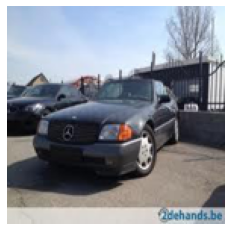

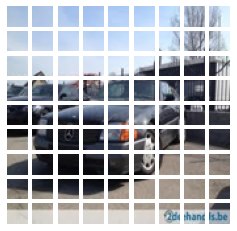

In [15]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

Implement the patch encoding layer

The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [16]:
class PatchEncoder(Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

Build the ViT model
The ViT model consists of multiple Transformer blocks, which use the layers.MultiHeadAttention layer as a self-attention mechanism applied to the sequence of patches. The Transformer blocks produce a [batch_size, num_patches, projection_dim] tensor, which is processed via an classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the paper, which prepends a learnable embedding to the sequence of encoded patches to serve as the image representation, all the outputs of the final Transformer block are reshaped with layers.Flatten() and used as the image representation input to the classifier head. Note that the layers.GlobalAveragePooling1D layer could also be used instead to aggregate the outputs of the Transformer block, especially when the number of patches and the projection dimensions are large.

In [17]:
inputs = Input(shape=(input_shape))
# Augment data.
augmented = data_augmentation(inputs)
# Create patches.
patches = Patches(patch_size)(augmented)
# Encode patches.
encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

# Create multiple layers of the Transformer block.
for _ in range(transformer_layers):
    # Layer normalization 1.
    x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)
    # Create a multi-head attention layer.
    attention_output = MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim, dropout=0.1
    )(x1, x1)
    # Skip connection 1.
    x2 = Add()([attention_output, encoded_patches])
    # Layer normalization 2.
    x3 = LayerNormalization(epsilon=1e-6)(x2)
    # MLP.
    x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
    # Skip connection 2.
    encoded_patches = Add()([x3, x2])

# Create a [batch_size, projection_dim] tensor.
representation = LayerNormalization(epsilon=1e-6)(encoded_patches)
representation = GlobalAveragePooling1D()(representation)
# au dessus ou representation = Flatten()(representation)
representation = Dropout(0.5)(representation)
# Add MLP.
features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
# Classify outputs.
logits = Dense(num_classes)(features)
# Create the Keras model.
model = Model(inputs=inputs, outputs=logits)

In [18]:
optimizer = tfa.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
)
model.compile(
    optimizer=optimizer,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        SparseCategoricalAccuracy(name="accuracy"),
        SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1,
    callbacks=[checkpoint_callback],
)

model.load_weights(checkpoint_filepath)
_, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

Epoch 1/100
3/3 [==============================] - 12s 877ms/step - loss: 2.3087 - accuracy: 0.1252 - top-5-accuracy: 0.5036 - val_loss: 2.2975 - val_accuracy: 0.1519 - val_top-5-accuracy: 0.6076
Epoch 2/100
3/3 [==============================] - 1s 317ms/step - loss: 2.2824 - accuracy: 0.1622 - top-5-accuracy: 0.5704 - val_loss: 2.2901 - val_accuracy: 0.1646 - val_top-5-accuracy: 0.5949
Epoch 3/100
3/3 [==============================] - 1s 192ms/step - loss: 2.2731 - accuracy: 0.1536 - top-5-accuracy: 0.5804 - val_loss: 2.3035 - val_accuracy: 0.1392 - val_top-5-accuracy: 0.5443
Epoch 4/100
3/3 [==============================] - 1s 197ms/step - loss: 2.2421 - accuracy: 0.1721 - top-5-accuracy: 0.6373 - val_loss: 2.2708 - val_accuracy: 0.1519 - val_top-5-accuracy: 0.5823
Epoch 5/100
3/3 [==============================] - 1s 317ms/step - loss: 2.2554 - accuracy: 0.1878 - top-5-accuracy: 0.6003 - val_loss: 2.2725 - val_accuracy: 0.1772 - val_top-5-accuracy: 0.5823
Epoch 6/100
3/3 [=======

In [19]:
def show_perfs(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

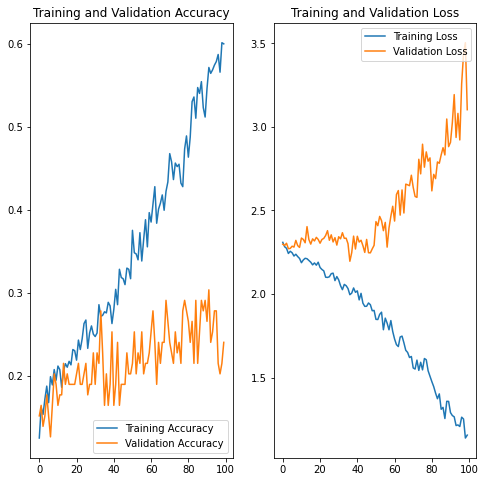

In [20]:
show_perfs(history, num_epochs)

To improve the model quality without pre-training, you can try to train the model for more epochs, use a larger number of Transformer layers, resize the input images, change the patch size, or increase the projection dimensions. Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices, but also by parameters such as the learning rate schedule, optimizer, weight decay, etc. In practice, it's recommended to fine-tune a ViT model that was pre-trained using a large, high-resolution dataset.

Avec des images de 72x72 et une patch_size de 6 j'ai obtenu :
- Test accuracy: 21.43%
- Test top 5 accuracy: 67.35%



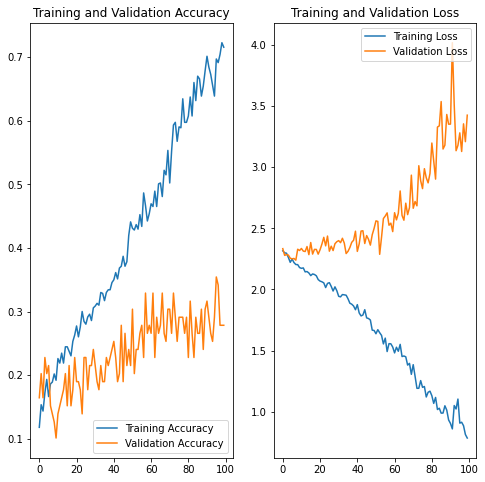

Avec des images de 72x72 et une patch_size de 8 j'ai obtenu :
- Test accuracy: 24.49%
- Test top 5 accuracy: 71.43%

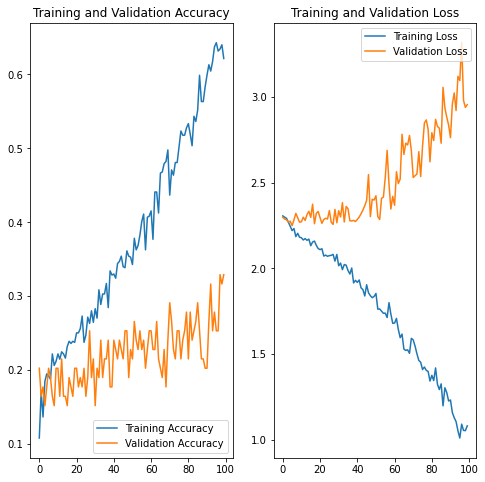

Avec des images de 100x100 et une patch_size de 10 j'ai obtenu :
- Test accuracy: 21.43%
- Test top 5 accuracy: 67.35%

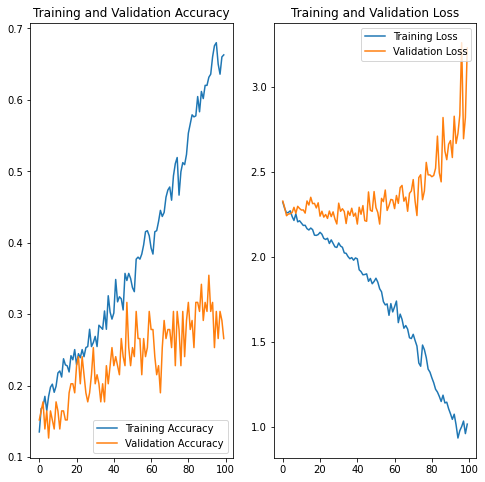

J'ai repris le meilleur ratio (72 / 8) et doublé la résolution : images de 144x144 et patch_size de 16 :
- Test accuracy: 20.92%
- Test top 5 accuracy: 70.41%
Mais c'est finalement moins bon...

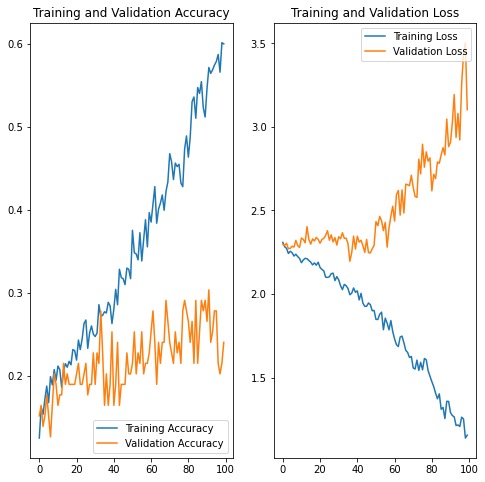

3D Object Representations for Fine-Grained Categorization
       Jonathan Krause, Michael Stark, Jia Deng, Li Fei-Fei
       4th IEEE Workshop on 3D Representation and Recognition, at ICCV 2013 (3dRR-13). Sydney, Australia. Dec. 8, 2013.
       [pdf]   [BibTex]   [slides]

Note that the dataset, as released, has 196 categories, one less than in the paper, as it has been cleaned up slightly since publication. Numbers should be more or less comparable, though.